In [19]:
import itertools
from itertools import combinations
from multiprocessing import Pool, cpu_count
import functools
from typing import List, Tuple, Union, Optional, Dict
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.sparse as sp
from scipy.linalg import expm, logm
import sparse
from tqdm import tqdm
import openfermion as of
from openfermion.chem import MolecularData
import openfermionpyscf
from sympy.combinatorics import Permutation 
import numba as nb

# Source: https://github.com/aguschanchu/fermionic-mbody
from fermionic_mbody import FixedBasis, rho_m_gen, rho_m

# Constants for STO-3G (H2O)
N_SPIN_ORBITALS = 14
N_ELECTRONS = 10
N_SPATIAL_ORBITALS = N_SPIN_ORBITALS // 2
N_UP = N_ELECTRONS // 2

## Setup

#### H2O Hamiltonian generation (PySCF)

In [2]:
def generate_h2o_hamiltonian(r: float, theta_deg: float = 104.5) -> Tuple[Optional[sp.spmatrix], Optional[MolecularData], MolecularData]:
    """
    Generates the sparse Hamiltonian for the H2O molecule in the STO-3G basis.

    Args:
        r: The O-H bond length in Angstrom.
        theta_deg: The H-O-H bond angle in degrees.
    """
    theta = np.deg2rad(theta_deg)
    x, z = r * np.sin(theta/2), r * np.cos(theta/2)
    geometry = [
        ('O', (0.0, 0.0, 0.0)),
        ('H', ( x, 0.0, z)),
        ('H', (-x, 0.0, z))
    ]
    
    molecule_s = MolecularData(
        geometry=geometry,
        basis='sto-3g',
        multiplicity=1,
        charge=0
    )
    
    try:
        molecule = openfermionpyscf.run_pyscf(
            molecule_s,
            run_scf=1,
            run_mp2=1,
            run_cisd=1,
            run_ccsd=1,
            run_fci=1
        )
    except Exception as e:
        print(f"Warning: PySCF run failed at R={r:.4f}. Error: {e}")
        return None, None, molecule_s

    molecular_hamiltonian = molecule.get_molecular_hamiltonian()
    qubit_hamiltonian = of.jordan_wigner(molecular_hamiltonian)
    sparse_hamiltonian = of.get_sparse_operator(qubit_hamiltonian)
    
    return sparse_hamiltonian, molecule, molecule_s

#### Space helpers

In [3]:
def find_frozen_spin_orbitals(rho1: Union[np.ndarray, sp.spmatrix], occ_thr_core: float = 0.98, occ_thr_virt: float = 0.02) -> Tuple[List[int], List[int], List[int]]:
    """
    Identifies core, virtual, and active spin orbitals based on 1-RDM occupations
    """
    if sp.issparse(rho1):
        occ = np.real(rho1.diagonal())
    else:
        occ = np.real(np.diag(rho1))
        
    idx = np.arange(len(occ))

    core_spin = idx[occ >= occ_thr_core].tolist()
    virt_spin = idx[occ <= occ_thr_virt].tolist()
    active_spin = [p for p in idx if p not in core_spin + virt_spin]
    return core_spin, virt_spin, active_spin

def strip_frozen_orbitals(H_full: Union[sp.spmatrix, np.ndarray],
                          core_spin: List[int],
                          basis: FixedBasis) -> Tuple[Union[sp.spmatrix, np.ndarray], FixedBasis]:
    """
    Projects the Hamiltonian onto a reduced Hilbert space by freezing core orbitals

    Parameters
    ----------
    H_full : Hamiltonian in the canonical determinant basis.
    core_spin : Spin-orbital indices to freeze as always-occupied.
    basis : The FixedBasis object representing the full Fock sector.

    Returns
    -------
    H_active : 2-D matrix
    basis_active : FixedBasis
    """
    n_spin, n_elec = basis.d, basis.m
    k_frozen    = len(core_spin)
    d_active    = n_spin  - k_frozen
    n_active    = n_elec  - k_frozen


    parent = basis

    mask_core = sum(1 << p for p in core_spin)

    keep_full = [i for i, m in enumerate(parent.num_ele)
                 if (m & mask_core) == mask_core]

    # --- active basis ----------------------------------------------------
    basis_active = FixedBasis(d_active, n_active)
    index_active = {m: i for i, m in enumerate(basis_active.num_ele)}

    full2act = []
    core_spin_set = set(core_spin)
    for i in keep_full:
        mask = parent.num_ele[i]
        new_mask = 0
        shift = 0
        for b in range(n_spin):
            if b in core_spin_set:
                shift += 1
            elif mask & (1 << b):
                new_mask |= 1 << (b - shift)
        full2act.append(index_active[new_mask])

    # This reordering ensures the resulting H_active matches the basis_active ordering.
    full2act = np.asarray(full2act)
    H_sub    = H_full[np.ix_(keep_full, keep_full)]
    
    if sp.issparse(H_sub):
        H_active = H_sub[full2act][:, full2act]
    else:
        H_active = H_sub[np.ix_(full2act, full2act)]

    return H_active, basis_active

In [4]:
# Canonical basis 
basis_c = FixedBasis(d=N_SPIN_ORBITALS, num=N_ELECTRONS)

# Restrict to Sz=0 subspace (5 UP, 5 DOWN)
# Using OpenFermion spin convention (even=UP, odd=DOWN)
mask_up_spins = sum(1 << i for i in range(0, N_SPIN_ORBITALS, 2))

idx_equal = []
for idx, ket_mask in enumerate(basis_c.num_ele):
    n_up_in_ket = bin(ket_mask & mask_up_spins).count('1')
    
    if n_up_in_ket == N_UP:
        idx_equal.append(idx)

# Create the restricted basis (Sz=0)
basis_r = FixedBasis.from_subset(basis_c, idx_equal)

# Basis for the UP subsystem (Isomorphic to DOWN subsystem)
basis_up = FixedBasis(d=N_SPATIAL_ORBITALS, num=N_UP)

In [5]:
def split_indices(op: of.FermionOperator, basis_subsystem: FixedBasis) -> Tuple[int, int, int]:
    """
    Decomposes a determinant operator into UP and DOWN components and calculates the fermionic sign
    
    |Det⟩ = sign * |UP⟩⊗|DOWN⟩ in the tensor product basis convention.
    """
    mask_up, mask_dn = 0, 0
    try:
        indices = sorted([p for p, _ in next(iter(op.terms.keys()))])
    except StopIteration:
        raise ValueError("Input operator is empty.")
    
    down_indices = []
    
    for p in indices:
        spatial_idx = p // 2
        if p % 2 == 0: 
            mask_up |= 1 << spatial_idx
        else: 
            mask_dn |= 1 << spatial_idx
            down_indices.append(p)

    # Calculate the fermionic sign (Phase factor)
    # The sign is (-1)^P, where P is the number of swaps required to move all UP operators before DOWN operators.
    sign_power = 0
    for p_dn in down_indices:
        count = sum(1 for p in indices if p > p_dn and p % 2 == 0)
        sign_power += count

    sign = 1 if sign_power % 2 == 0 else -1

    # Find indices in the subsystem basis.
    try:
        mask2idx = basis_subsystem._mask2idx
        i = mask2idx[mask_up]
        j = mask2idx[mask_dn]
    except (AttributeError, KeyError):
        i = int(np.where(basis_subsystem.num_ele == mask_up)[0][0])
        j = int(np.where(basis_subsystem.num_ele == mask_dn)[0][0])
        
    return i, j, sign

# Maps (UP_IDX, DOWN_IDX) -> (index in basis_r, sign)
sub2idx: Dict[Tuple[int, int], Tuple[int, int]] = {} 
for k, op in enumerate(basis_r.base):
    i_up, j_dn, sign = split_indices(op, basis_up)
    sub2idx[(i_up, j_dn)] = (k, sign)

def vect_to_tensor_array(vect: np.ndarray, basis_r: FixedBasis, basis_up: FixedBasis, up: bool = False) -> np.ndarray:
    """
    Converts a state vector or density matrix from the FCI basis (basis_r) to the
    reduced (UP/DOWN) basis, handles fermionic signs, and performs a partial trace
    """
    prod_dim = basis_up.size

    if vect.ndim == 1:
        vect = np.outer(vect, vect)

    # We must transform ρ from the FCI basis to the Tensor Product (TP) basis using the signs before tracing.
    reorder = np.empty(prod_dim**2, dtype=int)
    signs = np.empty(prod_dim**2, dtype=float)
    
    for i in range(prod_dim):
        for j in range(prod_dim):
            idx = i * prod_dim + j
            k, sign = sub2idx[(i, j)]
            reorder[idx] = k
            signs[idx] = sign

    rho_perm = np.array(vect[np.ix_(reorder, reorder)])
    
    # ρ_TP = diag(signs) @ ρ_perm @ diag(signs)†
    rho_TP = rho_perm * np.outer(signs, signs)

    rho4D = rho_TP.reshape(prod_dim, prod_dim, prod_dim, prod_dim)
    if up:
        rho_res = np.trace(rho4D, axis1=1, axis2=3)
    else:
        rho_res = np.trace(rho4D, axis1=0, axis2=2)
    return rho_res

def vect_to_C_matrix(vect: np.ndarray, basis_up: FixedBasis, sub2idx_map: Dict) -> np.ndarray:
    """
    Converts a state vector from the FCI basis (basis_r) to the 
    coefficient matrix C in the tensor product basis (|UP>⊗|DOWN>).
    
    |Ψ⟩ = Σ_{ij} C_ij |i_UP⟩⊗|j_DOWN⟩
    """
    prod_dim = basis_up.size
    C = np.zeros((prod_dim, prod_dim), dtype=np.complex128)
    
    # Iterate over the mapping (i_up, j_dn) -> (k_fci, sign)
    for (i, j), (k, sign) in sub2idx_map.items():
        if k < len(vect):
            # C_ij = <i_UP|<j_DOWN|Ψ> = sign * <Det_k|Ψ> = sign * vect[k]
            C[i, j] = sign * vect[k]
    return C

## Natural basis rotation (Sparseness optimization)

In [6]:
def natural_basis_rotation(basis: FixedBasis, rho_1: Optional[Union[np.ndarray, sparse.COO]] = None, U: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Calculates the basis transformation matrix V corresponding to a
    single-particle rotation U (V_IJ = det(U[I, J]))
    """
    if U is None:
        if rho_1 is None:
            raise ValueError("Either rho_1 or U must be provided.")
            
        if hasattr(rho_1, 'todense'):
             rho_1_dense = rho_1.todense()
        else:
             rho_1_dense = np.asarray(rho_1)

        # Calculate natural orbitals
        evals, evects = scipy.linalg.eigh(rho_1_dense)
        U = evects[:, ::-1]

    d = basis.d
    occupied_indices_list = []
    for mask in basis.num_ele:
        indices = [i for i in range(d) if (mask >> i) & 1]
        occupied_indices_list.append(indices)
    
    levels = np.array(occupied_indices_list)

    row_indices = levels[:, np.newaxis, :, np.newaxis]
    col_indices = levels[np.newaxis, :, np.newaxis, :]

    submatrices = U[row_indices, col_indices]
    V = np.linalg.det(submatrices)
    
    return V

In [7]:
"""
Optimization setup
"""
# Obtain Hamiltonian at the dissociated limit 
R_dissociation = 3.0
h_gc, _, _ = generate_h2o_hamiltonian(R_dissociation)

if h_gc is None:
    # Try perturbing slightly if it failed
    h_gc, _, _ = generate_h2o_hamiltonian(R_dissociation + 1e-4*np.random.random())
    if h_gc is None:
        raise RuntimeError(f"Hamiltonian generation failed at R={R_dissociation}")

# Project Hamiltonian onto Sz=0 basis
H_r = h_gc[np.ix_(basis_r.num_ele, basis_r.num_ele)].real

# Find the ground state
e, v = scipy.sparse.linalg.eigsh(H_r, k=1, which='SA', tol=1e-8)
fund = v[:, 0]

# Decompose the ground state 
C = vect_to_C_matrix(fund, basis_up, sub2idx)

# Calculate subsystem density matrices
rho_1_arrays = rho_m_gen(basis_up, 1)
rho_up = C @ C.T.conj()
rho_down = C.T.conj() @ C
rho_1_up = rho_m(rho_up, rho_1_arrays)
rho_1_down = rho_m(rho_down, rho_1_arrays)

# Calculate the rotation to the Natural Orbital (NO) basis
V_up = natural_basis_rotation(basis_up, rho_1=rho_1_up)
V_down = natural_basis_rotation(basis_up, rho_1=rho_1_down)

# Rotate C to the NO basis
Cn = V_up.T.conj() @ C @ V_down

ρ_1 (V3.1 Numba): 100%|██████████| 35/35 [00:00<00:00, 8459.67it/s]


In [8]:
# Optimization Helpers

def rho_to_seed(rho_1: Union[np.ndarray, sparse.COO]) -> np.ndarray:
    """Generates an optimization seed corresponding to the natural orbital rotation."""
    if hasattr(rho_1, 'todense'):
         rho_1_dense = rho_1.todense()
    else:
         rho_1_dense = np.asarray(rho_1)

    evals, evects = scipy.linalg.eigh(rho_1_dense)
    U = evects[:, ::-1]
    
    if np.linalg.det(U) < 0:
        U[:, -1] *= -1
        
    return encode(U)

def encode(U: np.ndarray) -> np.ndarray:
    """Encodes an orthogonal matrix U into parameters of the generating antisymmetric matrix A (U = exp(A))."""
    A = logm(U)
    A = 0.5 * (A - A.T) 
    triu_indices = np.triu_indices(U.shape[0], k=1)
    params = A[triu_indices].real
    return params

def decode(params: np.ndarray) -> np.ndarray:
    """Decodes parameters into an orthogonal matrix U = exp(A)."""
    n = int((1 + np.sqrt(1 + 8 * len(params))) // 2)
    A = np.zeros((n, n))
    triu_indices = np.triu_indices(n, k=1)
    A[triu_indices] = params
    A -= A.T
    U = expm(A)
    return U

# Cost functions

def hoyer_sparsity(c: np.ndarray) -> float:
    """Calculates the Hoyer sparsity measure (0=dense, 1=sparse)."""
    n = c.size
    if n <= 1: return 1.0
    
    c_flat = c.flatten()
    L1 = np.sum(np.abs(c_flat))
    L2 = np.sqrt(np.sum(np.abs(c_flat)**2))
    
    if L2 < 1e-12: return 1.0 # Handle zero vector
        
    return (np.sqrt(n) - L1 / L2) / (np.sqrt(n) - 1)

def l0_combined(C: np.ndarray, threshold=1e-3, alpha=0.1, beta=1.0, temperature=0.01) -> float:
    """Calculates a combined L1 and smoothed L0 norm cost function."""
    abs_C = np.abs(C)
    L1 = np.sum(abs_C)
    # Smoothed L0 norm using sigmoid
    sigmoid_mask = 1 / (1 + np.exp(-(abs_C - threshold) / temperature))
    smoothed_L0 = np.sum(sigmoid_mask)
    
    return alpha * L1 + beta * smoothed_L0

def loss(C: np.ndarray) -> float:
    """Selected loss function to minimize (maximize sparsity)."""
    return l0_combined(C)

def opti_fun(seed: np.ndarray, C_ref: np.ndarray, basis_sub: FixedBasis) -> float:
    """Optimization objective function"""
    half_len = len(seed) // 2
    params_up, params_down = seed[:half_len], seed[half_len:]
    
    U_up, U_down = decode(params_up), decode(params_down)
    V_up = natural_basis_rotation(basis_sub, U=U_up)
    V_down = natural_basis_rotation(basis_sub, U=U_down)
    
    # Rotate the coefficient matrix
    Ce = V_up.T.conj() @ C_ref @ V_down.conj()
    return loss(Ce)

# Calculate seed
seed_up = rho_to_seed(rho_1_up)
seed_down = rho_to_seed(rho_1_down)
init_seed = np.concatenate([seed_up, seed_down])

# Main optimization
print("Starting basis optimization...")
opt_m = scipy.optimize.basinhopping(
    opti_fun,
    init_seed,
    minimizer_kwargs={
        "method":"L-BFGS-B",
        "options":{"disp": True},
        "args": (C, basis_up) 
    },
)

# Rotate the state
seed = opt_m.x
params_up, params_down = seed[:len(seed)//2], seed[len(seed)//2:]
U_up, U_down = decode(params_up), decode(params_down)
Vop_up = natural_basis_rotation(basis_up, U=U_up)
Vop_down = natural_basis_rotation(basis_up, U=U_down)
Cop = Vop_up.T.conj() @ C @ Vop_down

loss(C), loss(Cn), loss(Cop)


Starting basis optimization...


(217.3256228541577, 215.80367881880406, 215.48540705529808)

## Dissociation curve analysis

#### Restricted RDM arrays generation

In [9]:
"""
Arrays blocks computation
"""

def _extract_sparse_block(arr: sparse.COO, row_terms: np.ndarray, col_terms: np.ndarray) -> sparse.COO:
    """Extracts a sub-block from a sparse COO tensor and remaps indices."""
    if not isinstance(row_terms, np.ndarray): row_terms = np.array(row_terms)
    if not isinstance(col_terms, np.ndarray): col_terms = np.array(col_terms)

    row_mask = np.isin(arr.coords[0], row_terms)
    col_mask = np.isin(arr.coords[1], col_terms)
    keep = row_mask & col_mask

    coords = arr.coords[:, keep]
    data   = arr.data[keep]

    # Remap indices
    row_map = {old: new for new, old in enumerate(row_terms)}
    col_map = {old: new for new, old in enumerate(col_terms)}
    
    coords[0] = np.vectorize(row_map.get)(coords[0])
    coords[1] = np.vectorize(col_map.get)(coords[1])

    shape = (len(row_terms), len(col_terms), arr.shape[2], arr.shape[3])
    return sparse.COO(coords, data, shape)


def rho2_block_antisym(basis: FixedBasis, rho2_full: Optional[sparse.COO] = None, upup: bool = True) -> sparse.COO:
    """
    Extracts spin-specific blocks of the 2-RDM generator tensor in the antisymmetrized basis
    """
    if rho2_full is None:
        rho2_full = rho_m_gen(basis, 2)

    t_basis = FixedBasis(basis.d, 2)
    terms   = []
    
    for idx, mask in enumerate(t_basis.num_ele):
        p = int(np.log2(int(mask) & -int(mask)))
        q = int(np.log2(int(mask) ^ (1 << p)))

        p_spin, q_spin = p % 2, q % 2

        if upup:
            # Same spin (UPUP or DNDN)
            if p_spin == q_spin:
                terms.append(idx)
        else:
            # Opposite spin (UPDOWN)
            if p_spin != q_spin:
                terms.append(idx)

    return _extract_sparse_block(rho2_full, terms, terms)

# --- Ordered Blocks ---

def so_idx(spatial: int, spin: int) -> int:
    """Maps spatial orbital index and spin (0=↑, 1=↓) to spin-orbital index"""
    return 2*spatial + spin

def _rho2_ext_worker(chunk, basis: FixedBasis, sig: int, tau: int):
    """
    Worker function for rho2_block_ordered
    """
    coords, vals = [], []
    d = basis.d // 2
    n_qubits = basis.d
    
    # Pre-fetch basis indices for slicing
    basis_indices = basis.num_ele

    for i, j, k, l in chunk:
        i, j, k, l = map(int, (i, j, k, l))

        # Operator: c†_{k,sig} c†_{l,tau} c_{j,tau} c_{i,sig}
        op_str = (
            (so_idx(k, sig), 1), (so_idx(l, tau), 1),
            (so_idx(j, tau), 0), (so_idx(i, sig), 0)
        )
        op = of.FermionOperator(op_str)

        # Calculate matrix representation in the full Fock space (computationally expensive)
        mat = of.get_sparse_operator(op, n_qubits=n_qubits)
        mat_restricted = mat[basis_indices, :][:, basis_indices].real
            
        r, c = mat_restricted.nonzero()
        row, col = i * d + j, k * d + l
        for rr, cc, vv in zip(r, c, mat_restricted.data):
            coords.append([row, col, rr, cc])
            vals.append(vv)
    return coords, vals

def rho2_block_ordered(basis: FixedBasis, upup: bool = True, n_workers: Optional[int] = None) -> sparse.COO:
    """
    Generates the 2-RDM generator tensor in an ordered (non-antisymmetrized) basis of spatial orbitals.
    Shape (d_spatial², d_spatial², N_dim, N_dim).
    """
    if n_workers is None:
        n_workers = max(1, cpu_count()//2)

    d = basis.d // 2
    shape = (d**2, d**2, basis.size, basis.size)

    if upup:
        spin_cases = [(0, 0)] # ↑↑ (or ↓↓)
    else:
        spin_cases = [(0, 1)] # ↑↓

    work = list(itertools.product(range(d), repeat=4))
    chunks = np.array_split(work, n_workers)

    coords, vals = [], []
    desc = f"ρ₂-ordered ({'↑↑' if upup else '↑↓'})"

    for sig, tau in spin_cases:
        if n_workers == 1:
            for chunk in tqdm(chunks, desc=desc):
                c, v = _rho2_ext_worker(chunk, basis, sig, tau)
                coords.extend(c); vals.extend(v)
        else:
            with Pool(n_workers) as pool:
                jobs = ((chunk, basis, sig, tau) for chunk in chunks)
                results = pool.starmap(_rho2_ext_worker, jobs)
                for c, v in tqdm(results, total=len(chunks), desc=desc):
                    coords.extend(c); vals.extend(v)

    if not coords:
        return sparse.COO([], [], shape=shape)
        
    coords_T = np.asarray(coords).T
    return sparse.COO(coords_T, vals, shape=shape)

def partial_transpose(rho: np.ndarray, perm: List[int], d: Optional[int] = None) -> np.ndarray:
    """
    Performs a permutation of indices (partial transpose) on a matrix (d² x d²).

    Args:
        rho: The density matrix (d² x d²).
        perm: The permutation of axes for the reshaped tensor.
        d: The dimension of the subsystems. 
    """
    rho = np.asarray(rho)
    
    if d is None:
        d = int(np.sqrt(rho.shape[0]))
        if d*d != rho.shape[0]:
            raise ValueError("Input matrix must be square with dimension d².")
    
    rho_tensor = rho.reshape((d, d, d, d))
    rho_permuted_tensor = rho_tensor.transpose(np.argsort(perm))
    rho_p = rho_permuted_tensor.reshape((d**2, d**2))
    
    return rho_p

#### States computation

In [10]:
# --- Configuration ---
state_type = 'gs' 
BETA = 1000
# R (distance) range
dists = np.linspace(0.1, 4.0, 50)

# RDM Array Generation
rho_1_extended = rho_m_gen(basis_r, 1)
rho_2_extended = rho_m_gen(basis_r, 2)
rho_2_extended_upup_as = rho2_block_antisym(basis_r, rho_2_extended, upup=True)
rho_2_extended_updown_as = rho2_block_antisym(basis_r, rho_2_extended, upup=False)
rho_2_extended_upup = rho2_block_ordered(basis_r, upup=True)
rho_2_extended_updown = rho2_block_ordered(basis_r, upup=False)

ρ₂-ordered (↑↓): 100%|██████████| 4/4 [00:00<00:00, 1517.48it/s]


In [11]:
import scipy.sparse.linalg
from typing import Dict

def calculate_dissociation_curve(dists: np.ndarray, 
                                 basis_r: FixedBasis, 
                                 state_type: str = 'gs', 
                                 level: int = 0, 
                                 BETA: float = 1000.0,
                                 degeneracy_tol: float = 1e-6) -> Dict[float, Union[np.ndarray, np.ndarray]]:
    """
    Calculates the specified energy level (GS or excited) or thermal state.
    Handles degeneracies by returning a density matrix (normalized projector) if the level is degenerate.
    """
    states = {}
    prev_vecs = None 
    print(f"Calculating dissociation curve (Type: {state_type}, Level: {level})...")
    
    k_extra = 1 if level != 0 else 0
    k_request = level + 1 + k_extra

    for R in tqdm(dists, desc="R"):
        R = float(R)
        
        # Generate Hamiltonian 
        H_full, *_ = generate_h2o_hamiltonian(R)
        if H_full is None:
            H_full, *_ = generate_h2o_hamiltonian(R + 1e-4 * np.random.random())
            if H_full is None:
                print(f"Skipping R={R:.4f}.")
                continue

        # Project Hamiltonian
        H = H_full[np.ix_(basis_r.num_ele, basis_r.num_ele)].real

        # Calculate State
        if state_type == 'gs':
            k_eff = min(k_request, H.shape[0] - 1)
            if k_eff <= 0: continue

            try:
                # Use the previous vector corresponding to the level as the initial guess 
                v0 = prev_vecs[:, level] if prev_vecs is not None and prev_vecs.shape[1] > level else None

                ncv = max(2 * k_eff + 5, min(H.shape[0] - 1, 40))
                E, V = scipy.sparse.linalg.eigsh(H, k=k_eff, which='SA', v0=v0, tol=1e-14, ncv=ncv)
                
                if len(E) <= level:
                    print(f"Warning: Fewer states ({len(E)}) found than requested level ({level}) at R={R:.4f}.")
                    continue

                sort_idx = np.argsort(E)
                E = E[sort_idx]
                V = V[:, sort_idx]

                # Update initial guesses 
                norms = np.linalg.norm(V, axis=0)
                valid_mask = norms > 1e-9
                if np.any(valid_mask):
                   V_norm = V[:, valid_mask] / norms[valid_mask]
                   prev_vecs = V_norm
                
                # Degeneracy Handling
                target_energy = E[level]
                # Identify all states within the tolerance
                degenerate_indices = np.where(np.abs(E - target_energy) < degeneracy_tol)[0]
                
                if len(degenerate_indices) > 1:
                    V_subspace = V[:, degenerate_indices]
                    D = V_subspace.shape[1]
                    # ρ = (1/D) * V @ V†
                    rho_projector = (V_subspace @ V_subspace.conj().T) / D
                    states[R] = rho_projector
                else:
                    states[R] = V[:, level]

            except (scipy.sparse.linalg.ArpackNoConvergence, scipy.sparse.linalg.ArpackError) as e:
                print(f"Warning: Eigensolver failed at R={R:.4f} for level {level}. Skipping. Error: {e}")
                prev_vecs = None # Clear guesses if failed
                continue

        elif state_type == 'thermal':
            H_dense = H.todense() if hasattr(H, 'todense') else H
            E, V = np.linalg.eigh(H_dense)
            weights = np.exp(-BETA * (E - E.min()))
            weights /= weights.sum()
            rho_thermal = V @ np.diag(weights) @ V.conj().T
            states[R] = rho_thermal
        else:
            raise ValueError(f"Unknown state_type: {state_type}.")

    return states

if state_type == 'gs':
    states = calculate_dissociation_curve(dists, basis_r, state_type = 'gs', level = 0)
elif state_type == 'thermal':
    states = calculate_dissociation_curve(dists, basis_r, state_type ='thermal', beta = BETA)
else:
    print('Invalid state_type provided')

Calculating dissociation curve (Type: gs, Level: 0)...


R: 100%|██████████| 50/50 [06:00<00:00,  7.21s/it]


#### Plots

100%|██████████| 50/50 [00:00<00:00, 341.21it/s]


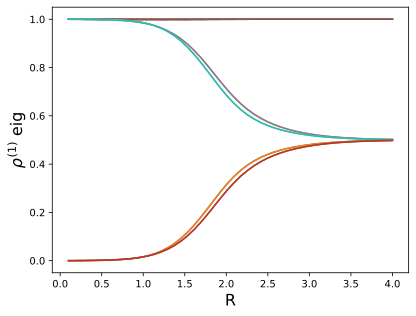

100%|██████████| 50/50 [00:01<00:00, 36.13it/s]


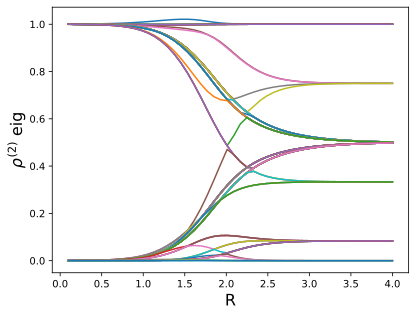

100%|██████████| 50/50 [00:00<00:00, 112.94it/s]


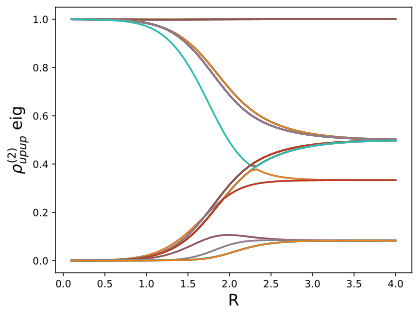

100%|██████████| 50/50 [00:00<00:00, 58.98it/s]


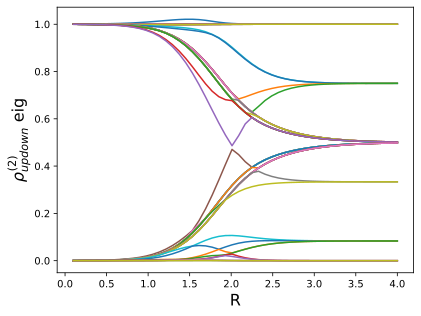

100%|██████████| 50/50 [00:01<00:00, 48.19it/s]


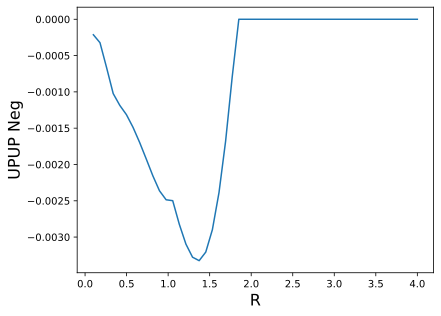

100%|██████████| 50/50 [00:00<00:00, 50.56it/s]


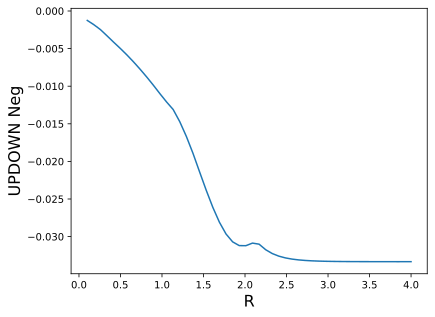

100%|██████████| 50/50 [00:00<00:00, 50.62it/s]


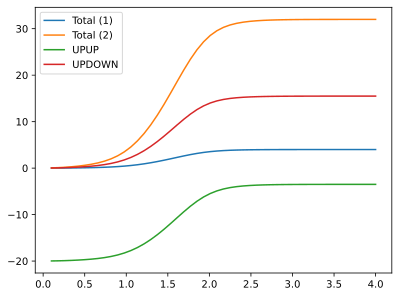

100%|██████████| 50/50 [00:00<00:00, 68.15it/s]


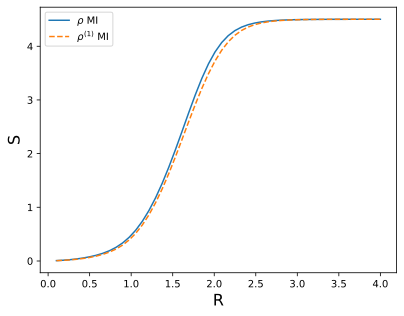

In [12]:
import matplotlib.pyplot as plt

def S_vn(rho: np.ndarray) -> float:
    """
    Calculates the von Neumann entropy S = -Tr(ρ_norm log2(ρ_norm))
    """
    eigvals = np.linalg.eigvalsh(rho)
    
    trace = np.sum(eigvals)
    if abs(trace) < 1e-9:
        return 0.0
        
    eigvals = eigvals[eigvals > 1e-12]
    
    return -np.sum(eigvals * np.log2(eigvals))

def plot_rho(states_dict: dict, rho_arrays: sparse.COO, label: str = r'$\rho^{(m)}$ eig'):
    """Calculates and plots the eigenvalues of the m-RDM."""
    ds = sorted(list(states_dict.keys()))
    if not ds: return None
        
    res = np.zeros(shape=(len(ds),rho_arrays.shape[0]))
    
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        state = states_dict[d]
        rho = rho_m(state, rho_arrays)
        rho_dense = rho.todense() if hasattr(rho, 'todense') else rho
        
        eigvals = np.linalg.eigvalsh(rho_dense)
        res[idx] = np.sort(eigvals)[::-1]

    plt.figure()
    plt.plot(ds, res)
    plt.xlabel(r'R', fontsize=16) 
    plt.ylabel(label, fontsize=16)
    plt.show()
    return res

def m_entropy(states_dict: dict, rho_arrays: sparse.COO) -> np.ndarray:
    """Calculates the m-body entropy S(ρ(m))."""
    ds = sorted(list(states_dict.keys()))
    res = np.zeros(shape=(len(ds)))
    
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        state = states_dict[d]
        rho = rho_m(state, rho_arrays)
        rho_dense = rho.todense() if hasattr(rho, 'todense') else rho
        res[idx] = S_vn(rho_dense)

    return res

def plot_neg(states_dict: Dict[float, np.ndarray], 
             rho_arrays: sparse.COO, 
             label: str = r'SNE', 
             second: bool = False, 
             normalize: bool = True):
    """
    Calculates and plots the sum of negative eigenvalues of the partially transposed 2-RDM block.
    """
    ds = sorted(list(states_dict.keys()))
    if not ds: return None

    res = np.zeros(shape=(len(ds)))
    d_sub = int(np.sqrt(rho_arrays.shape[0]))

    # Permutations 
    perm_main = [0, 3, 2, 1]
    perm_second = [0, 2, 3, 1]

    for idx, R in tqdm(enumerate(ds), total=len(ds)):
        state = states_dict[R]
        
        # Calculate the RDM block
        rho = rho_m(state, rho_arrays)
        rho_dense = rho.todense() if hasattr(rho, 'todense') else np.asarray(rho)
        
        if normalize:
            trace_val = np.trace(rho_dense).real
            if abs(trace_val) > 1e-9:
                rho_dense = rho_dense / trace_val
            else:
                continue

        # Apply partial transpose combinations
        rho_pt = partial_transpose(rho_dense, perm_main, d=d_sub)
        if second:
             rho_pt -= partial_transpose(rho_dense, perm_second, d=d_sub)

        eigvals = np.linalg.eigvals(rho_pt)
        sne = np.sum([x.real for x in eigvals if x.real < -1e-12])
        res[idx] = sne

    plt.figure()
    plt.plot(ds, res)
    plt.xlabel(r'R', fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.show()
    return res

def plot_density_up(states_dict: dict):
    """Plots the eigenvalues of the reduced density matrix ρ_UP (for thermal states)."""    
    prod_dim = basis_up.size
    ds = sorted(list(states_dict.keys()))
    res = np.zeros(shape=(len(ds), basis_up.size))

    for idx, R in tqdm(enumerate(ds), total=len(ds)):
        rho = np.array(states_dict[R])        
        rho_up = vect_to_tensor_array(rho, basis_r, basis_up, up=True)

        eigvals = np.linalg.eigvalsh(rho_up)
        res[idx] = np.sort(eigvals)[::-1]

    plt.figure()
    plt.plot(ds, res)
    plt.xlabel(r'R', fontsize=16)
    plt.ylabel( r'$\rho_{UP}$ eig', fontsize=16)
    plt.show()
    return res

def plot_mutual_information(states_dict: dict):
    """
    Plots the mutual information of states and RDM
    """    
    ds = sorted(list(states_dict.keys()))
    res_d, res_rho = np.zeros(shape=(len(ds))), np.zeros(shape=(len(ds)))

    for idx, R in tqdm(enumerate(ds), total=len(ds)):
        rho = states_dict[R]
        if rho.ndim == 1:
            rho = np.outer(rho, rho)

        # Calculate UP/DOWN density matrix (partial trace)
        rho_up = vect_to_tensor_array(rho, basis_r, basis_up, up = True)
        rho_down = vect_to_tensor_array(rho, basis_r, basis_up, up = False)

        # Calculate 1,2-RDM
        rho_1_up = rho_m(rho_up, rho_1_arrays).todense()
        #rho_1_up *= np.trace(rho_1_up)
        rho_1_down = rho_m(rho_down, rho_1_arrays).todense()
        #rho_1_down *= np.trace(rho_1_down)
        rho_2_updown = rho_m(rho, rho_2_extended_updown_as).todense()

        res_d[idx] = S_vn(rho_up) + S_vn(rho_down) - S_vn(rho)
        res_rho[idx] = S_vn(rho_1_up)*np.trace(rho_1_up) + S_vn(rho_1_down)*np.trace(rho_1_down) - S_vn(rho_2_updown)

    plt.figure()
    plt.plot(ds, res_d, label=r'$\rho$ MI')
    plt.plot(ds, res_rho, linestyle='dashed', label=r'$\rho^{(1)}$ MI')
    plt.xlabel(r'R', fontsize=16)
    plt.ylabel( r'S', fontsize=16)
    plt.legend()
    plt.show()


# RDM Eigenvalues
plot_rho(states, rho_1_extended, label = r'$\rho^{(1)}$ eig')
plot_rho(states, rho_2_extended, label = r'$\rho^{(2)}$ eig')
plot_rho(states, rho_2_extended_upup_as, label = r'$\rho^{(2)}_{upup}$ eig')
plot_rho(states, rho_2_extended_updown_as, label = r'$\rho^{(2)}_{updown}$ eig')
plot_neg(states, rho_2_extended_upup, label = r'UPUP Neg', second = True)
plot_neg(states, rho_2_extended_updown, label = r'UPDOWN Neg')

# M-entropy
ds = list(states.keys())
plt.plot(ds, m_entropy(states, rho_1_extended),label='Total (1)')
plt.plot(ds, m_entropy(states, rho_2_extended),label='Total (2)')
plt.plot(ds, m_entropy(states, rho_2_extended_upup), label='UPUP')
plt.plot(ds, m_entropy(states, rho_2_extended_updown), label='UPDOWN')
plt.legend()
plt.show()

# Mutual information
plot_mutual_information(states)


In [13]:
m_entropy(states, rho_1_extended)

100%|██████████| 50/50 [00:00<00:00, 323.88it/s]


array([0.00626778, 0.01268392, 0.02180575, 0.03503738, 0.05200219,
       0.07347152, 0.10099364, 0.136717  , 0.18358996, 0.2452212 ,
       0.325816  , 0.42993333, 0.56193515, 0.72524456, 0.92167125,
       1.15101157, 1.41088506, 1.6965544 , 2.00057502, 2.31251694,
       2.61933501, 2.90685875, 3.16229122, 3.37690034, 3.54771538,
       3.67736072, 3.77218936, 3.83985867, 3.8874997 , 3.92087086,
       3.9442504 , 3.96067392, 3.972249  , 3.98042953, 3.98622082,
       3.99032257, 3.99322556, 3.99527645, 3.99672143, 3.99773596,
       3.9984453 , 3.99893886, 3.9992805 , 3.99951564, 3.99967617,
       3.99978558, 3.99985874, 3.99991164, 3.99994045, 3.99996185])

In [14]:
eee = states[0.1]
idx = np.where(np.abs(eee) > 1e-1)[0]
for x in idx:
    print(basis_c.base[int(x)], eee[x])

1.0 [0^ 1^ 2^ 5^ 6^ 7^ 9^ 10^ 11^ 13^] -0.9998909039058885


## Dissociated limit analysis

In [15]:
# --- Hamiltonian Generation and Diagonalization (R=4) ---
R_DISSOCIATION = 4.0
H_sparse_full, molecule, molecule_s = generate_h2o_hamiltonian(R_DISSOCIATION)

# Restrict the full Hamiltonian to the N-electron subspace (basis_c)
H_N = H_sparse_full[np.ix_(basis_c.num_ele, basis_c.num_ele)].real

# Restrict further to the Sz=0 subspace (basis_r)
H_R = H_N[np.ix_(idx_equal, idx_equal)]
H = H_R.todense()
H = np.asarray(H)

# --- RDM Tensor Generation ---
rho_1_arrays_r = rho_m_gen(basis_r, m=1)
rho_2_arrays_r = rho_m_gen(basis_r, m=2)

ρ_2 (V3.1 Numba): 100%|██████████| 64/64 [00:00<00:00, 193.42it/s]


In [16]:
# --- Diagonalization and Ground State Subspace ---
eigvals, eigvects = np.linalg.eigh(H)

# Identify the ground state subspace 
E_GS = eigvals[0]
# Use a tighter tolerance to accurately identify degeneracy
TOL_DEGENERACY = 1e-3
idx = np.where(eigvals < E_GS + TOL_DEGENERACY)[0]
dimension = len(idx)
eigen_space = eigvects[:, idx]

print(f"GS energy: {E_GS:.6f}")
print(f"Degeneracy: {dimension}")

# --- Spin Verification ---
# Get S^2 and Sz operators 
sz_op_full = of.get_sparse_operator(of.hamiltonians.sz_operator(N_SPATIAL_ORBITALS), n_qubits=N_SPIN_ORBITALS)
s2_op_full = of.get_sparse_operator(of.hamiltonians.s_squared_operator(N_SPATIAL_ORBITALS), n_qubits=N_SPIN_ORBITALS)

# Restrict operators to the basis_r subspace
sz_op = sz_op_full[np.ix_(basis_r.num_ele, basis_r.num_ele)]
s2_op = s2_op_full[np.ix_(basis_r.num_ele, basis_r.num_ele)]

for i in range(dimension):
    state = eigen_space[:, i]
    # Calculate expectation values 
    exp_S2 = np.real(state.conj().T @ (s2_op @ state))
    exp_Sz = np.real(state.conj().T @ (sz_op @ state))
    
    # Calculate Spin S from <S^2> = S(S+1). S = (-1 + sqrt(1 + 4*<S^2>))/2
    S_val = (-1 + np.sqrt(1 + 4*exp_S2))/2
    print(f"  State {i}: <S^2> = {float(exp_S2):.4f}, <S_z> = {float(exp_Sz):.4f}")

GS energy: -74.737318
Degeneracy: 12
  State 0: <S^2> = 0.0000, <S_z> = 0.0000
  State 1: <S^2> = 2.0000, <S_z> = 0.0000
  State 2: <S^2> = 0.0000, <S_z> = 0.0000
  State 3: <S^2> = 2.0000, <S_z> = 0.0000
  State 4: <S^2> = 2.0000, <S_z> = 0.0000
  State 5: <S^2> = 0.0000, <S_z> = 0.0000
  State 6: <S^2> = 2.0000, <S_z> = 0.0000
  State 7: <S^2> = 6.0000, <S_z> = 0.0000
  State 8: <S^2> = 6.0000, <S_z> = 0.0000
  State 9: <S^2> = 2.0000, <S_z> = 0.0000
  State 10: <S^2> = 2.0000, <S_z> = 0.0000
  State 11: <S^2> = 6.0000, <S_z> = 0.0000


##### Zero purity subspace 

We define the purity as N - Tr(ρ1^2). Minimizing this (towards 0) finds the states closest to SDs.

In [20]:
def precalculate_projected_RDM(eigen_space, rho_1_arrays_r):
    """
    Projects the 1-RDM tensor onto the degenerate subspace basis
    R1[i, j, a, b] = <E_a| rho_1[i,j] |E_b>
    """
    k = eigen_space.shape[1]
    if k == 0:
        return None
        
    E = eigen_space
    
    # R1[i, j, a, b] = sum_{r,c} E[r,a] * Gamma[i,j,r,c] * E[c,b]
    R1 = sparse.einsum("ijrc,ra,cb->ijab", rho_1_arrays_r, E, E)
    R1_dense = R1.todense()

    return R1_dense

@nb.njit(cache=True)
def purity_defect_numba(coefs, R1_dense, N_elec):
    """
    Calculates N - Tr(rho1^2) using the pre-calculated projected RDM
    """
    N_orb = R1_dense.shape[0]
    k_dim = R1_dense.shape[2]
    
    # Calculate normalization factor
    norm_sq = 0.0
    for i in range(len(coefs)):
        norm_sq += coefs[i]**2
        
    if norm_sq < 1e-18: return 0.0
    
    # rho_1 = sum_{a,b} c_a c_b R1[i,j,a,b] / norm_sq
    rho_1 = np.zeros((N_orb, N_orb), dtype=np.float64)
    
    for a in range(k_dim):
        for b in range(k_dim):
            factor = (coefs[a] * coefs[b]) / norm_sq
            for i in range(N_orb):
                for j in range(N_orb):
                    rho_1[i, j] += factor * R1_dense[i, j, a, b]

    # Calculate Tr(rho_1^2). Tr(A^2) = sum_ij (A_ij)^2
    rho_1_sq_trace = 0.0
    for i in range(N_orb):
        for j in range(N_orb):
            val = rho_1[i, j]
            rho_1_sq_trace += val * val

    defect = N_elec - rho_1_sq_trace
    return max(0.0, defect)


# --------------------------------------------------------------------------
# Identification of SD subspace 
# --------------------------------------------------------------------------

MAX_ITERATIONS = 200 
DEFECT_THRESHOLD = 1e-5
R1_DENSE = precalculate_projected_RDM(eigen_space, rho_1_arrays_r)
local_minima_arr = []

objective_fn = lambda coefs: purity_defect_numba(coefs, R1_DENSE, N_ELECTRONS)

# Search for local minima
for i in tqdm(range(MAX_ITERATIONS), desc="SD Search"):
    seed = np.random.uniform(-1, 1, dimension)
    seed /= np.linalg.norm(seed)

    opt = scipy.optimize.minimize(
        objective_fn,
        seed,
        method="SLSQP",
        constraints={'type': 'eq', 'fun': lambda c: np.dot(c, c) - 1},
        options={'ftol': 1e-9}
    )

    if opt.success and objective_fn(opt.x) < DEFECT_THRESHOLD:
        local_minima_arr.append(opt.x)

# Use SVD to determine the dimensionality
if len(local_minima_arr) > 0:
    local_minima_matrix = np.array(local_minima_arr).T
    U, S, Vh = np.linalg.svd(local_minima_matrix)
    SVD_TOL = 1e-4
    idx = np.where(S > SVD_TOL)[0]
    sd_dim = len(idx)
    sd_space = U[:, idx]
    print(f"Found {len(local_minima_arr)} SD solutions. Dimension of the SD subspace: {sd_dim}")
else:
    print("No SD found.")
    sd_dim = 0
    sd_space = np.empty((dimension, 0))

# --------------------------------------------------------------------------
# Optimization of subspace bases 
# --------------------------------------------------------------------------

def param_to_A(theta: np.ndarray, dim: int) -> np.ndarray:
    """Constructs an antisymmetric matrix A."""
    A = np.zeros((dim, dim), dtype=float)
    tri_indices = np.triu_indices(dim, 1)
    A[tri_indices] = theta
    A -= A.T
    return A

def total_purity_defect_loss(B, R1_dense, N_elec):
    """Calculates the sum of purity defects"""
    res = 0.0
    for j in range(B.shape[1]):
        # The columns of B are the coefficients 'coefs'
        res += purity_defect_numba(B[:, j], R1_dense, N_elec)
    return res

def objective_rotation(theta, B_initial, R1_dense, N_elec):
    """Calculates the total loss for the rotated basis."""
    k_dim = B_initial.shape[1]
    A = param_to_A(theta, k_dim)
    U = scipy.linalg.expm(A)
    B_rotated = B_initial @ U
    return total_purity_defect_loss(B_rotated, R1_dense, N_elec)

def optimize_subspace_basis(B_initial: np.ndarray, R1_dense: np.ndarray, N_elec: int):
    k_dim = B_initial.shape[1]
    n_free = k_dim * (k_dim - 1) // 2
    theta0 = np.zeros(n_free)
    
    args_tuple = (B_initial, R1_dense, N_elec)
    niter = 50

    opt_res = scipy.optimize.basinhopping(
        objective_rotation,
        theta0,
        niter=niter,
        minimizer_kwargs={
            "method":"BFGS", 
            "options":{'disp': False, 'gtol': 1e-9},
            "args": args_tuple
        },
    )
    res = opt_res.lowest_optimization_result

    print(f"Final total purity defect: {res.fun:.6e}")

    A_opt = param_to_A(res.x, k_dim)
    U_opt = scipy.linalg.expm(A_opt)
    coeffs_opt = B_initial @ U_opt
    return coeffs_opt

'''
We search for a unitary rotation within the sd_space that minimizes the total purity
In other words, we are looking for an SDs basis for the zero purity subspace
'''

Q_sd, _ = np.linalg.qr(sd_space)
B_initial_sd = Q_sd[:, :sd_dim]
coeffs_rot_sd = optimize_subspace_basis(B_initial_sd, R1_DENSE, N_ELECTRONS)

sd_kets = eigen_space @ coeffs_rot_sd

# Identify and optimize the complementary subspace
Q_full, _ = np.linalg.qr(sd_space, mode="complete")
ort_space = Q_full[:, sd_dim:]

ort_dim = ort_space.shape[1]
B_initial_ort = ort_space
coeffs_rot_ort = optimize_subspace_basis(B_initial_ort, R1_DENSE, N_ELECTRONS)
ort_kets = eigen_space @ coeffs_rot_ort


SD Search: 100%|██████████| 200/200 [00:04<00:00, 46.37it/s]


Found 139 SD solutions. Dimension of the SD subspace: 6
Final total purity defect: 1.385204e-06
Final total purity defect: 6.000001e+00
